In [71]:
import os
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
import clip
from PIL import Image
import matplotlib.pyplot as plt
import csv

In [72]:
# Set device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [73]:
class SegmentationDataset(Dataset):
    def __init__(self, image_dir, mask_dir, csv_path, transform=None):
        self.image_dir = image_dir
        self.mask_dir = mask_dir
        self.transform = transform
        
        # Check if directories exist
        if not os.path.exists(image_dir):
            raise FileNotFoundError(f"Image directory not found: {image_dir}")
        if not os.path.exists(mask_dir):
            raise FileNotFoundError(f"Mask directory not found: {mask_dir}")
        
        self.class_labels = {}
        with open(csv_path, 'r') as f:
            reader = csv.reader(f)
            next(reader)  # Skip header
            for row in reader:
                self.class_labels[row[0]] = int(row[1])  # Store filename to label mapping
        
        # Get image files (accept both JPG and PNG)
        self.images = []
        for img in os.listdir(image_dir):
            if img.lower().endswith(('.jpg', '.jpeg', '.png')):
                self.images.append(os.path.join(image_dir, img))
        self.images.sort()
        
        # Get mask files (PNG only)
        self.masks = sorted([mask for mask in os.listdir(mask_dir) if mask.lower().endswith('.png')])

        
        # Check if there are any images and masks
        if len(self.images) == 0:
            raise ValueError(f"No JPG/PNG images found in {image_dir}")
        if len(self.masks) == 0:
            raise ValueError(f"No PNG masks found in {mask_dir}")
        
        # Match images and masks by base filename (without extension)
        # This ensures we can match .jpg images with .png masks
        # Match images with masks based on filenames
        self.matched_pairs = []
        mask_basenames = {os.path.splitext(os.path.basename(mask))[0]: mask for mask in self.masks}

        for img_path in self.images:
            img_basename = os.path.splitext(os.path.basename(img_path))[0]
            if img_basename in mask_basenames:
                self.matched_pairs.append((img_path, mask_basenames[img_basename]))
        
        if len(self.matched_pairs) == 0:
            raise ValueError(f"No matching image-mask pairs found. Check that filenames match between directories.")
        
        print(f"Found {len(self.matched_pairs)} matched image-mask pairs in {image_dir} and {mask_dir}")
        
        # Load CLIP model
        try:
            self.clip_model, self.preprocess = clip.load("ViT-B/32", device=device)
            self.clip_model.eval()
        except Exception as e:
            print(f"Error loading CLIP model: {e}")
            raise

    def __len__(self):
        return len(self.matched_pairs)

    def __getitem__(self, idx):
        img_path, mask_path = self.matched_pairs[idx]
        mask_path = self.mask_dir + mask_path
        img_filename = os.path.basename(img_path)

        # Load image and mask
        try:
            image = Image.open(img_path).convert("RGB")
            mask = Image.open(mask_path).convert("L")  # Convert mask to grayscale
        except Exception as e:
            print(f"Error loading image/mask at index {idx}: {e}")
            return torch.zeros(512, dtype=torch.float32), torch.zeros(224, 224, dtype=torch.long)

        # Retrieve class label from CSV
        class_label = self.class_labels.get(img_filename, 0)  # Default to background if not found
        #print(class_label)

        # Convert class label to grayscale intensity (0: background, 1: 128, 2: 255)
        mask = np.array(mask, dtype=np.uint8)
        mask[mask != 0] = class_label
        mask = torch.tensor(mask, dtype=torch.long)
        
        # Convert mask to class grayscale value
        if self.transform:
            image = self.transform(image)

        # Get CLIP features
        with torch.no_grad():
            try:
                clip_input = self.preprocess(image).unsqueeze(0).to(device)
                image_features = self.clip_model.encode_image(clip_input)
                return image_features.squeeze(0).cpu(), mask
            except Exception as e:
                print(f"Error processing image with CLIP: {e}")
                return torch.zeros(512, dtype=torch.float32), mask

In [74]:
import math

class CLIPSegmentationNetwork(nn.Module):
    def __init__(self, clip_model_name="ViT-B/32", num_classes=3):
        super(CLIPSegmentationNetwork, self).__init__()
        
        # Load CLIP model
        self.clip_model, _ = clip.load(clip_model_name, device=device)
        
        # Freeze CLIP weights
        for param in self.clip_model.parameters():
            param.requires_grad = False

        embed_dim = 512
        
        # Decoder network
        self.decoder = nn.Sequential(
            nn.Conv2d(embed_dim, 256, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Upsample(scale_factor=2, mode='bilinear', align_corners=True),  # 7x7 -> 14x14
            nn.Conv2d(256, 128, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Upsample(scale_factor=2, mode='bilinear', align_corners=True),  # 14x14 -> 28x28
            nn.Conv2d(128, 64, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Upsample(scale_factor=2, mode='bilinear', align_corners=True),  # 28x28 -> 56x56
            nn.Conv2d(64, 32, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Upsample(scale_factor=2, mode='bilinear', align_corners=True),  # 56x56 -> 112x112
            nn.Conv2d(32, 16, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Upsample(scale_factor=2, mode='bilinear', align_corners=True),  # 112x112 -> 224x224
            nn.Conv2d(16, num_classes, kernel_size=1)
        )
    
    def forward(self, images):
        #print(f"Input shape: {images.shape}")
        # Extract spatial features from CLIP intermediate layers
        with torch.no_grad():  # Freeze CLIP weights
            # Get spatial features from CLIP (e.g. from the last attention layer)
            features = self.extract_spatial_features(images)
        #print(f"Features shape: {features.shape}")
        # Decode features to segmentation mask
        return self.decoder(features)
        
    def extract_spatial_features(self, images):
    # For pre-extracted CLIP features as input
        if images.dim() == 2:  # [batch_size, feature_dim]
            # Reshape to small spatial dimensions
            batch_size = images.size(0)
            features = images.view(batch_size, -1, 1, 1)  # [B, C, 1, 1]
            
            # Use a small convolutional network to upsample to 7x7
            features = features.expand(-1, -1, 7, 7)
            return features


In [75]:
def train_model(model, train_loader, val_loader, criterion, optimizer, num_epochs=10):
    model.to(device)
    best_val_loss = float('inf')
    
    for epoch in range(num_epochs):
        # Training
        model.train()
        train_loss = 0.0
        
        for clip_features, masks in train_loader:
            clip_features = clip_features.to(device)
            
            # Ensure masks are in correct format
            # If masks are [B, H, W] with class indices, convert to long tensor
            if masks.dim() == 3:
                masks = masks.long().to(device)  # Convert to class indices
            # If masks are one-hot encoded [B, C, H, W], convert to class indices
            elif masks.dim() == 4 and masks.size(1) == 3:  # Assuming 3 classes
                masks = torch.argmax(masks, dim=1).to(device)
            
            optimizer.zero_grad()
            outputs = model(clip_features)
            loss = criterion(outputs, masks)
            loss.backward()
            optimizer.step()
            
            train_loss += loss.item()
        
        avg_train_loss = train_loss / len(train_loader)
        
        # Validation
        model.eval()
        val_loss = 0.0
        
        with torch.no_grad():
            for clip_features, masks in val_loader:
                clip_features = clip_features.to(device)
                masks = masks.to(device)
                
                outputs = model(clip_features)
                loss = criterion(outputs, masks)
                
                val_loss += loss.item()
        
        avg_val_loss = val_loss / len(val_loader)
        
        print(f'Epoch {epoch+1}/{num_epochs}, Train Loss: {avg_train_loss:.4f}, Val Loss: {avg_val_loss:.4f}')
        
        # Save best model
        if avg_val_loss < best_val_loss:
            best_val_loss = avg_val_loss
            torch.save(model.state_dict(), 'best_clip_segmentation_model.pth')
    
    return model

In [76]:
def evaluate_model(model, test_loader):
    model.eval()
    
    # Use IoU as metric for segmentation
    class_iou = [0, 0, 0]  # IoU for each class
    class_count = [0, 0, 0]  # Count of images with each class
    
    with torch.no_grad():
        for clip_features, masks in test_loader:
            clip_features = clip_features.to(device)
            masks = masks.to(device)
            
            outputs = model(clip_features)
            _, preds = torch.max(outputs, 1)
            
            # Calculate IoU for each class
            for c in range(3):  # 3 classes
                if (masks == c).sum() > 0:  # If class exists in ground truth
                    class_count[c] += 1
                    intersection = ((preds == c) & (masks == c)).sum().float()
                    union = ((preds == c) | (masks == c)).sum().float()
                    iou = (intersection / union).item() if union > 0 else 0
                    class_iou[c] += iou
    
    # Calculate mean IoU
    mean_iou = sum(class_iou) / sum(class_count) if sum(class_count) > 0 else 0
    
    # Print results
    print(f"Mean IoU: {mean_iou:.4f}")
    for c in range(3):
        if class_count[c] > 0:
            print(f"Class {c} IoU: {class_iou[c]/class_count[c]:.4f}")
    
    return mean_iou

In [77]:
# Data directories
train_img_dir = "C:/Users/louis/Documents/UNI4/CV/CW/processed_dataset/color/"
train_mask_dir = "C:/Users/louis/Documents/UNI4/CV/CW/processed_dataset/label/"
train_csv_dir = "C:/Users/louis/Documents/UNI4/CV/CW/processed_dataset/labels.csv"
test_img_dir = "C:/Users/louis/Documents/UNI4/CV/CW/processed_dataset_test/color/"
test_mask_dir = "C:/Users/louis/Documents/UNI4/CV/CW/processed_dataset_test/label/"
test_csv_dir = "C:/Users/louis/Documents/UNI4/CV/CW/processed_dataset_test/labels.csv"

# Create datasets
train_dataset = SegmentationDataset(train_img_dir, train_mask_dir, train_csv_dir)
test_dataset = SegmentationDataset(test_img_dir, test_mask_dir, test_csv_dir)

# Split training data into train and validation
train_size = int(0.8 * len(train_dataset))
val_size = len(train_dataset) - train_size
train_subset, val_subset = torch.utils.data.random_split(train_dataset, [train_size, val_size])

# Create data loaders
train_loader = DataLoader(train_subset, batch_size=8, shuffle=True)
val_loader = DataLoader(val_subset, batch_size=8, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=8, shuffle=True)

# Initialize model
model = CLIPSegmentationNetwork(num_classes=3)

# Define loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Train model
model = train_model(model, train_loader, val_loader, criterion, optimizer, num_epochs=15)

# Load best model
model.load_state_dict(torch.load('best_clip_segmentation_model.pth'))

# Evaluate model
mean_iou = evaluate_model(model, test_loader)

Found 3680 matched image-mask pairs in C:/Users/louis/Documents/UNI4/CV/CW/processed_dataset/color/ and C:/Users/louis/Documents/UNI4/CV/CW/processed_dataset/label/
Found 3710 matched image-mask pairs in C:/Users/louis/Documents/UNI4/CV/CW/processed_dataset_test/color/ and C:/Users/louis/Documents/UNI4/CV/CW/processed_dataset_test/label/
Epoch 1/15, Train Loss: 0.4701, Val Loss: 0.3642
Epoch 2/15, Train Loss: 0.3520, Val Loss: 0.3576
Epoch 3/15, Train Loss: 0.3403, Val Loss: 0.3368
Epoch 4/15, Train Loss: 0.3272, Val Loss: 0.3317
Epoch 5/15, Train Loss: 0.3311, Val Loss: 0.3328
Epoch 6/15, Train Loss: 0.3149, Val Loss: 0.3345
Epoch 7/15, Train Loss: 0.3088, Val Loss: 0.3205
Epoch 8/15, Train Loss: 0.3018, Val Loss: 0.3246
Epoch 9/15, Train Loss: 0.3000, Val Loss: 0.3252
Epoch 10/15, Train Loss: 0.2935, Val Loss: 0.3316
Epoch 11/15, Train Loss: 0.2918, Val Loss: 0.3238
Epoch 12/15, Train Loss: 0.2877, Val Loss: 0.3228
Epoch 13/15, Train Loss: 0.2849, Val Loss: 0.3281
Epoch 14/15, Train 

8


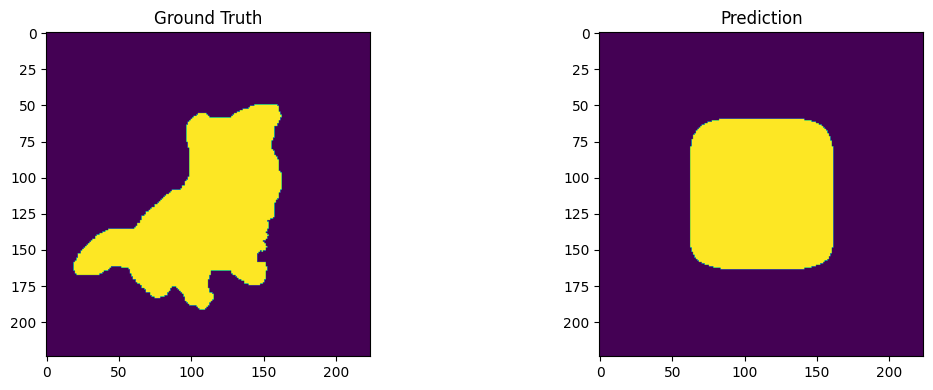

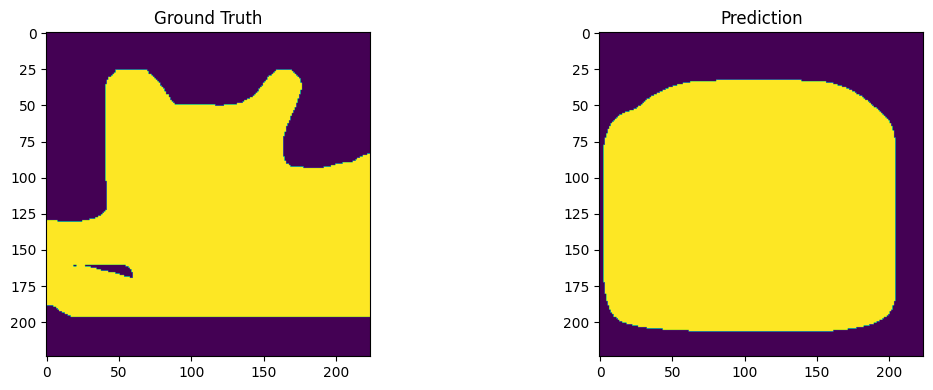

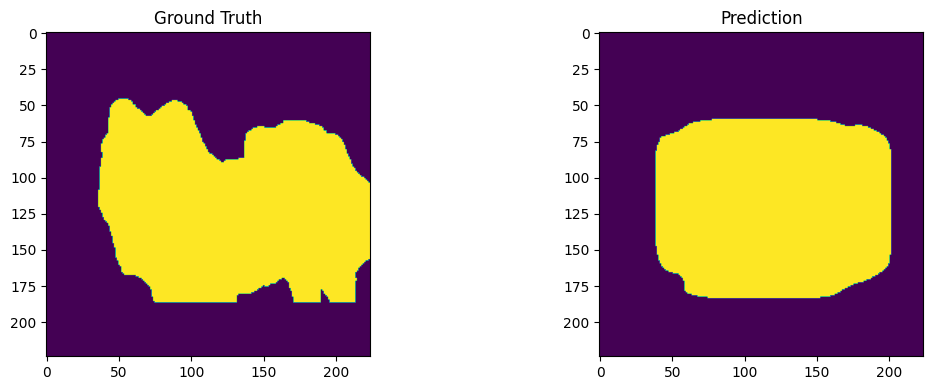

In [81]:
# Visualize some predictions
model.load_state_dict(torch.load('best_clip_segmentation_model.pth'))
model.eval()
test_loader = DataLoader(test_dataset, batch_size=8, shuffle=True)

with torch.no_grad():
    for clip_features, masks in test_loader:
        clip_features = clip_features.to(device)
        outputs = model(clip_features)
        _, preds = torch.max(outputs, 1)
        
        # Convert tensors to numpy for visualization
        preds = preds.cpu().numpy()
        masks = masks.cpu().numpy()
        print(len(preds))
        # Visualize first 3 samples
        for i in range(min(3, len(preds))):
            j = np.random.randint(1, len(preds) - 1)
            plt.figure(figsize=(12, 4))
            
            plt.subplot(1, 2, 1)
            plt.title("Ground Truth")
            plt.imshow(masks[j])
            
            plt.subplot(1, 2, 2)
            plt.title("Prediction")
            plt.imshow(preds[j])
            
            plt.tight_layout()
            plt.savefig(f"sample_{j}_prediction.png")
            plt.show()
            plt.close()
        
        break  # Just visualize one batch